In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [115]:
def make_fake_data() -> pd.DataFrame:
    """_Make some fake data for testing purposes.

    Returns:
        df (pd.DataFrame): DataFrame with time as index
    """

    t = np.linspace(0, 3, 200)**2
    y1 = np.sin(t)
    y2 = np.cos(1.3*t)
    y3 = np.heaviside(t-1, 0) - .5
    y = np.vstack((y1, y2, y3)).T
    y[175:, :] = np.array([[-.1, 0, .1]])
    df = pd.DataFrame(y, columns = ['signal1', 'signal2', 'signal3'], index= t)
    df.index.name = 't'
    print(df)
    return df


def normalize_data(df :  pd.DataFrame) -> pd.DataFrame:
    df = (df - df.min())/(df.max() - df.min())    
    return df


def get_distances(df) -> np.ndarray:
    
    """Calculates the linear interpolation error between two points and a set of intermediate points.

    Args:
        t1 (float): Time of the first point.
        y1 (np.ndarray): Values of the first point with shape (1, N_signals).
        t2 (float): Time of the second point.
        y2 (np.ndarray): Values of the first point with shape (1, N_signals).
        tn (np.ndarray): Vector of times of the intermediate points with length N_timepoints.
        yn (np.ndarray): Values of the intermediate points with shape (N_timepoints, N_signals). 

    Returns:
        error (np.ndarray): The linear interpolation error for each intermediate point with shape (N_timepoints, N_signals).
    """

    t1 = df.index[0].reshape(-1, 1)
    t2 = df.index[-1].reshape(-1, 1)      
    tn = df.index.values.reshape(-1, 1) 

    values = df.values

    m = (values[-1,:] -values[0,:])/(t2 - t1)
    y_fit = m * (tn - t1) + values[0,:]
    error = y_fit - values
    return error



def get_crit_points(df, tolerance = 0.01, normalize = True, include_global_extrema = True):

    if normalize == True:
        df = normalize_data(df)
        print('done normalizing')


    N_timepoints = len(df)
    N_signals = len(df.columns)
    I_crit = np.zeros(N_timepoints, dtype=bool)

    I_crit[0] = True
    I_crit[-1] = True

    if include_global_extrema:
        I_min = df.values.argmin(axis = 0)
        I_max = df.values.argmax(axis = 0)
        I_crit[I_min] = True
        I_crit[I_max] = True
        print('done adding global extrema')


    I_last_point = 0

    for i in range(1, N_timepoints):
        
        if I_crit[i-1] == True:
            I_last_point = i-1
        else:
           

            I_slice = df.index[I_last_point:i+1]
            df_cur = df.loc[I_slice,:]

            error = get_distances(df_cur)

            if np.any(np.abs(error) >tolerance):
                I_last_point = i-1
                I_crit[I_last_point] = True

    return I_crit


def calculate_linear_interp_error(t, y, I_crit):

    y_interpolated = np.zeros_like(y)
    for i in range(y.shape[1]):  # vectorize this later
        y_interpolated[:, i] = np.interp(t, t[I_crit], y[I_crit,i])
    error = y_interpolated - y

    return error


           signal1   signal2  signal3
t                                    
0.000000  0.000000  1.000000     -0.5
0.000227  0.000227  1.000000     -0.5
0.000909  0.000909  0.999999     -0.5
0.002045  0.002045  0.999996     -0.5
0.003636  0.003636  0.999989     -0.5
...            ...       ...      ...
8.641827 -0.100000  0.000000      0.1
8.730689 -0.100000  0.000000      0.1
8.820005 -0.100000  0.000000      0.1
8.909775 -0.100000  0.000000      0.1
9.000000 -0.100000  0.000000      0.1

[200 rows x 3 columns]
done normalizing
done adding global extrema
done normalizing
done adding global extrema
done normalizing
done adding global extrema


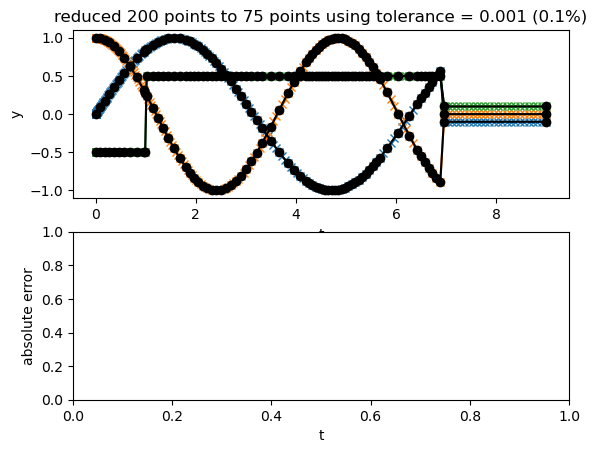

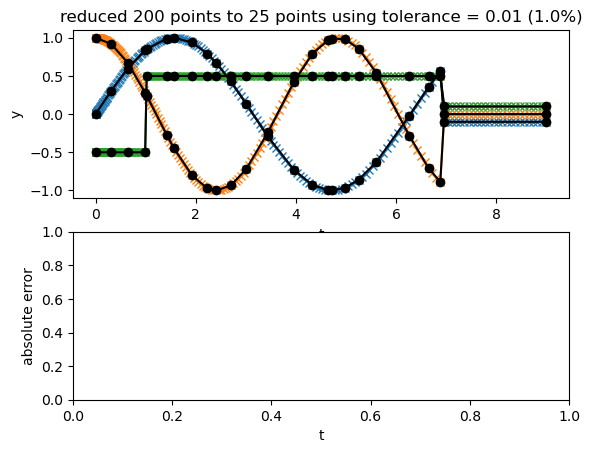

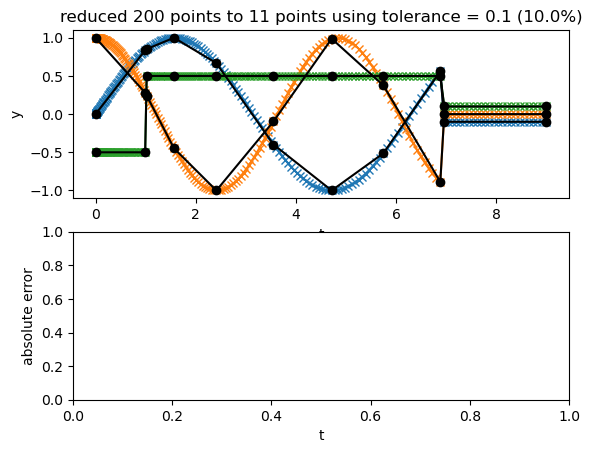

In [116]:
df = make_fake_data()

for tolerance in [0.001, 0.01, 0.1]:

    I_crit = get_crit_points(df, tolerance = tolerance)
    #error = calculate_linear_interp_error(df, I_crit)

    t = df.index
    tc = df.index[I_crit]

    fig, ax = plt.subplots(2, 1)    
    ax[0].plot(t, df, marker = 'x',)
    ax[0].plot(tc, df.loc[tc,:], marker = 'o', color = 'k')
    ax[0].set_title(f'reduced {len(df)} points to {np.sum(I_crit)} points using tolerance = {tolerance} ({tolerance*100:.1f}%)')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('y')
    #ax[1].plot(t, error)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('absolute error')



In [117]:

I_crit

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,